XGBoost to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution.
Test generalization by training and testing on different stations

In [9]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'20190728-135517'

In [14]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [15]:
test_station_fraction = 0.25
val_station_fraction = 0.1
num_test_stations = int(len(station_data_dict.keys()) * test_station_fraction)
num_val_stations = int(len(station_data_dict.keys()) * val_station_fraction)
test_stations = np.random.choice(list(station_data_dict.keys()), size=num_test_stations, replace=False)
train_stations = np.array(list(s for s in station_data_dict.keys() if s not in test_stations))
val_stations = np.random.choice(train_stations, size=num_val_stations, replace=False)
train_stations = np.array(list(s for s in station_data_dict.keys() if (s not in test_stations) and (s not in val_stations)))
train_stations, test_stations, val_stations

(array(['02GA010', '02GA038', '02GA047', '02GB001', '02GB007', '02GC018',
        '02GE007', '02GG002', '02GG003', '02GG006', '02GG009', '02GG013',
        '04159900', '04160600', '04161820', '04164000', '04165500',
        '04174500', '04176500', '04193500', '04195820', '04196800',
        '04197100', '04199500', '04200500', '04207200', '04209000',
        '04213000', '04213500', '04215000', '04215500'], dtype='<U8'),
 array(['02GC010', '04208504', '04214500', '04166100', '04212100',
        '04166500', '02GA018', '04159492', '02GC007', '04199000',
        '02GC026'], dtype='<U8'),
 array(['02GD004', '04177000', '02GC002', '04198000'], dtype='<U8'))

In [16]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

train = data[(data['date'] >= train_start) & (data['date'] <= train_end) & (data['station'].isin(train_stations))].copy()
val = data[(data['date'] >= train_start) & (data['date'] <= train_end) & (data['station'].isin(val_stations))].copy()    
test = data[(data['date'] >= test_start) & (data['date'] <= test_end) & (data['station'].isin(test_stations))].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff']), 
       (val.drop(['station', 'date', 'runoff'], axis=1), val['runoff'])]

m = xgb.XGBRegressor(n_estimators=1000, n_jobs=44, random_state=123, colsample_bylevel=.8357617548460161,
                    colsample_bytree=0.7279736118769715, gamma=0.8, learning_rate=.4, max_depth=3, min_child_weight=5,
                    reg_alpha=45.191905388077004, reg_lambda=8.021568667278883, subsample=0.9708847409794326)
m.fit(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff'], eval_set=val, eval_metric='rmse', early_stopping_rounds=100, verbose=True)

test = test[~pd.isna(test['runoff'])]

predict = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
predict['is_test_station'] = predict['station'].apply(lambda s: s in test_stations)
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff', 'is_test_station'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


Shapes: train (33653, 8727), val (4352, 8727), test (8030, 8727)


/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:56.1952	validation_1-rmse:47.4061
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:50.2984	validation_1-rmse:46.8879
[2]	validation_0-rmse:46.0522	validation_1-rmse:46.6284
[3]	validation_0-rmse:43.085	validation_1-rmse:46.5152
[4]	validation_0-rmse:41.1056	validation_1-rmse:46.4502
[5]	validation_0-rmse:39.1367	validation_1-rmse:46.4571
[6]	validation_0-rmse:37.5385	validation_1-rmse:46.2023
[7]	validation_0-rmse:36.4206	validation_1-rmse:46.1977
[8]	validation_0-rmse:35.1268	validation_1-rmse:46.1987
[9]	validation_0-rmse:34.2933	validation_1-rmse:46.2281
[10]	validation_0-rmse:33.17	validation_1-rmse:46.2407
[11]	validation_0-rmse:32.4726	validation_1-rmse:46.2263
[12]	validation_0-rmse:31.6707	validation_1-rmse:46.2454
[13]	validation_0-rmse:30.9241	validation_1-rmse:46.2539
[14]	validation_0-rmse:30.3721	validation_1-rmse:46.239

02GA010 	NSE: 0.3560515455421075 	MSE: 307.0175895341949 (clipped to 0)
02GA018 	NSE: 0.1558741908667498 	MSE: 212.00488170767196 (clipped to 0)
02GA038 	NSE: 0.22315447200753447 	MSE: 127.8209644480382 (clipped to 0)
02GA047 	NSE: 0.1525388625862132 	MSE: 66.43249946420477 (clipped to 0)
02GB001 	NSE: 0.2787403687471657 	MSE: 5416.569816498842 (clipped to 0)
02GB007 	NSE: 0.3074401961856392 	MSE: 21.657740246891702 (clipped to 0)
02GC002 	NSE: 0.18964742634659015 	MSE: 104.13276482698993 (clipped to 0)
02GC007 	NSE: -33.3395826923358 	MSE: 1034.3543993627668 (clipped to 0)
02GC010 	NSE: -17.62656334040544 	MSE: 1107.3476967156378 (clipped to 0)
02GC018 	NSE: 0.4797218209256596 	MSE: 35.23677707554499 (clipped to 0)
02GC026 	NSE: -4.549896925416806 	MSE: 892.605203276866 (clipped to 0)
02GD004 	NSE: -1.0806253549708909 	MSE: 114.56562666564922 (clipped to 0)
02GE007 	NSE: 0.35672029928745563 	MSE: 23.270680792034216 (clipped to 0)
02GG002 	NSE: 0.49825515120667885 	MSE: 121.01224077746

../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04165500 	NSE: 0.511117372058782 	MSE: 218.85266824013175 (clipped to 0)
04166100 	NSE: -9.747726233251326 	MSE: 78.81638339464116 (clipped to 0)
04166500 	NSE: -0.5620137453681726 	MSE: 53.98989976162272 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04174500 	NSE: 0.18698503611873174 	MSE: 76.89026954190443 (clipped to 0)
04176500 	NSE: -0.05793288059364632 	MSE: 722.6466733869006 (clipped to 0)
04177000 	NSE: -0.022061396859702764 	MSE: 27.54438070181016 (clipped to 0)
04193500 	NSE: 0.5523003277709448 	MSE: 31697.47224078216 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04195820 	NSE: 0.5778119527019857 	MSE: 495.56193833611275 (clipped to 0)
04196800 	NSE: 0.486142581446218 	MSE: 153.77105502465415 (clipped to 0)
04197100 	NSE: 0.4892348162158403 	MSE: 52.38632959227649 (clipped to 0)
04198000 	NSE: 0.22218844954611894 	MSE: 5746.129032488984 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04199000 	NSE: 0.12694836470123128 	MSE: 892.7854831399408 (clipped to 0)
04199500 	NSE: 0.3860714953541633 	MSE: 248.42501642272467 (clipped to 0)
04200500 	NSE: 0.4402383592697958 	MSE: 560.1562480057581 (clipped to 0)
04207200 	NSE: 0.3339131763063773 	MSE: 15.590622222954352 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04208504 	NSE: -0.495989048179172 	MSE: 1460.8761748681754 (clipped to 0)
04209000 	NSE: 0.5358673687356283 	MSE: 145.11385938624383 (clipped to 0)
04212100 	NSE: 0.1792818560651609 	MSE: 1205.080999326481 (clipped to 0)
04213000 	NSE: 0.4144483302824795 	MSE: 105.08851102706933 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04213500 	NSE: 0.6277679867433505 	MSE: 381.32074403898145 (clipped to 0)
04214500 	NSE: 0.023943799903081264 	MSE: 117.65097116167037 (clipped to 0)
04215000 	NSE: 0.3556250243181275 	MSE: 61.89402892494143 (clipped to 0)
04215500 	NSE: 0.4897100135677315 	MSE: 92.15067206306323 (clipped to 0)
Train Median NSE (clipped to 0) 0.37497776884158907 / Min -1.0806253549708909 / Max 0.6277679867433505
Train Median MSE (clipped to 0) 104.13276482698993 / Min 14.789213175784143 / Max 31697.47224078216
Test Median NSE (clipped to 0) -0.495989048179172 / Min -33.3395826923358 / Max 0.1792818560651609
Test Median MSE (clipped to 0) 892.605203276866 / Min 53.98989976162272 / Max 1460.8761748681754


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


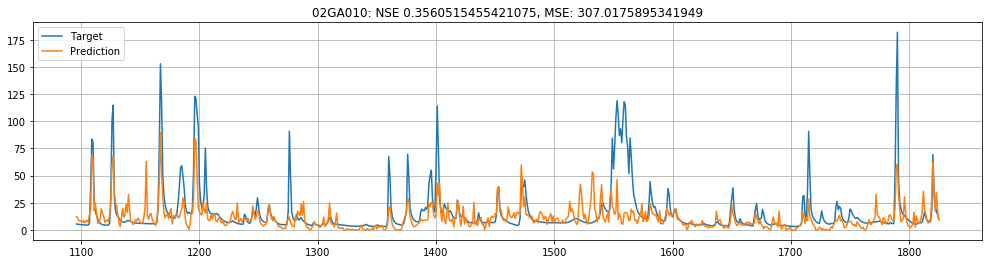

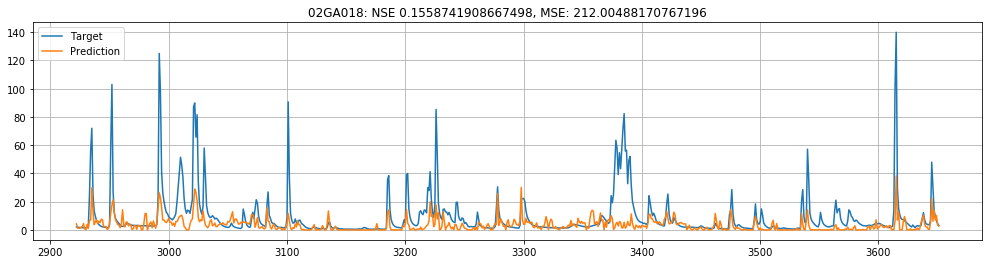

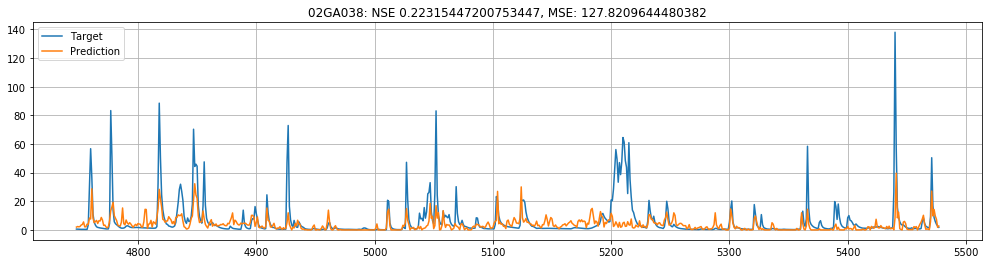

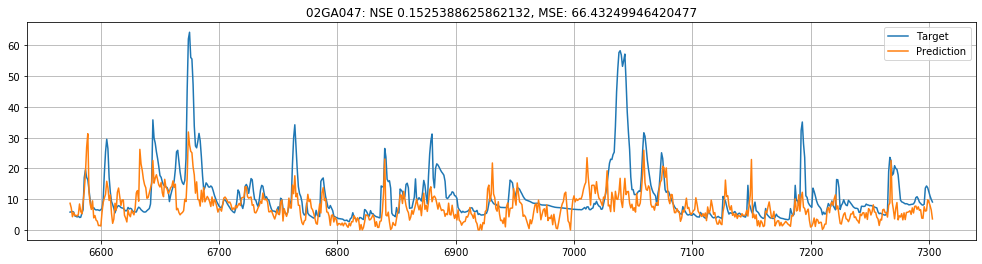

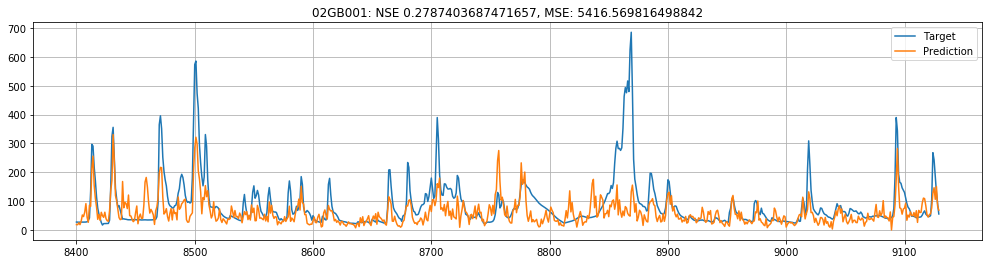

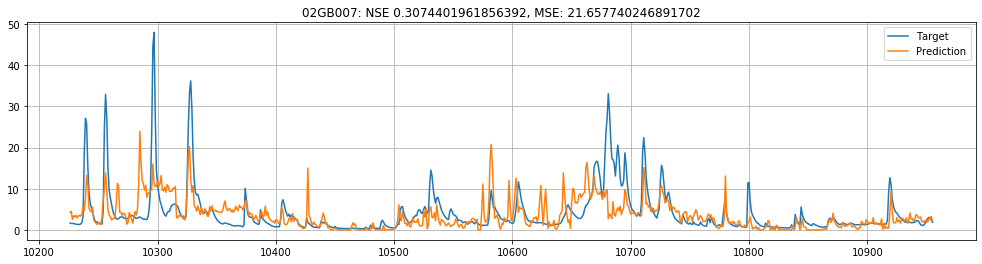

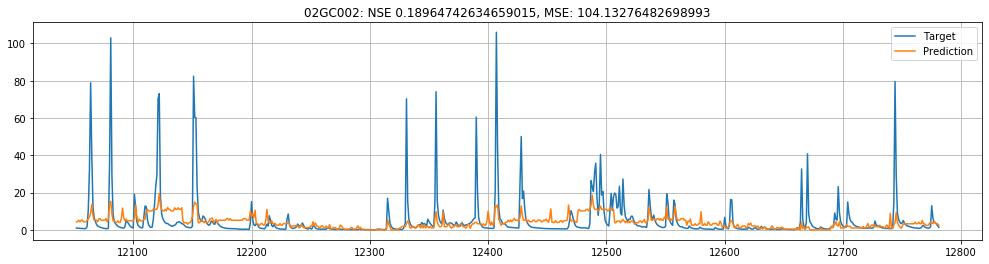

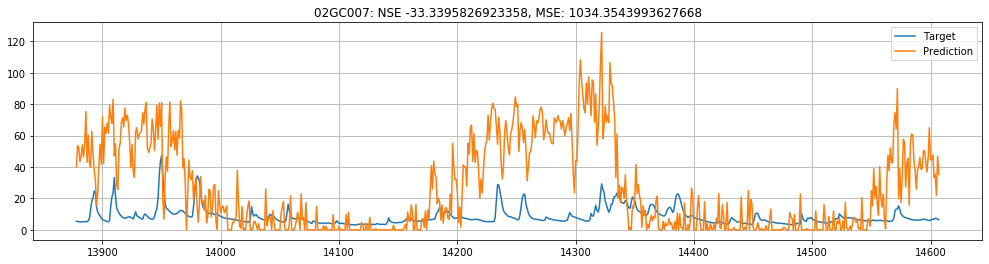

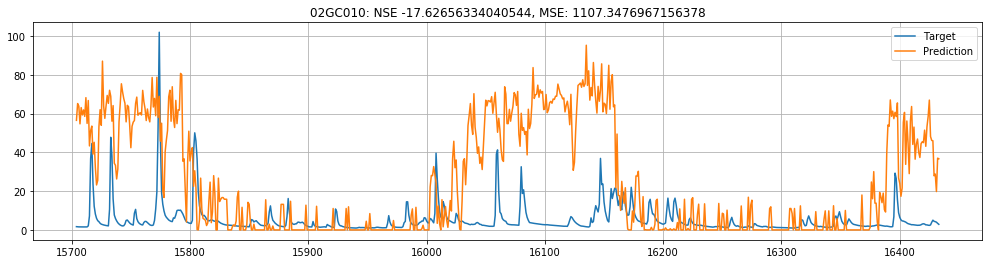

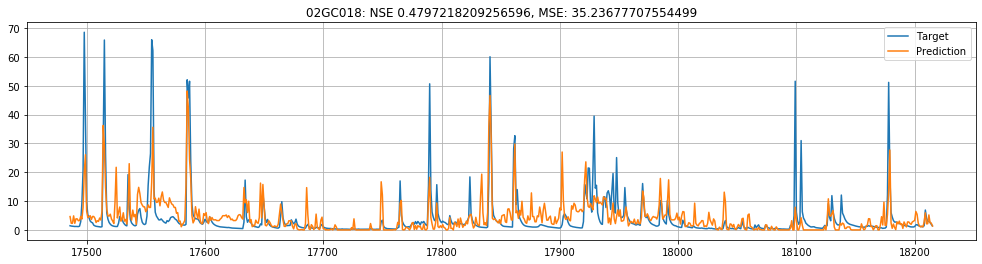

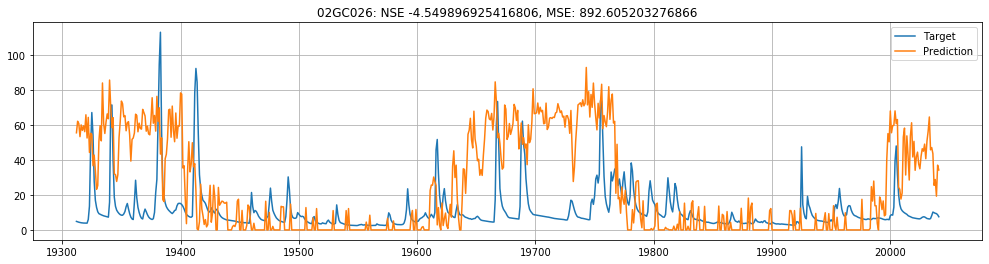

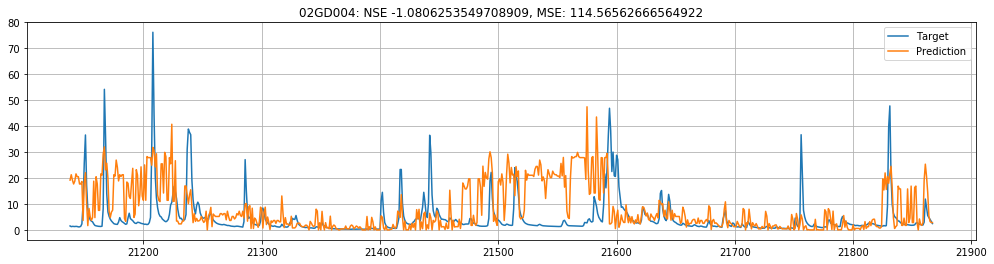

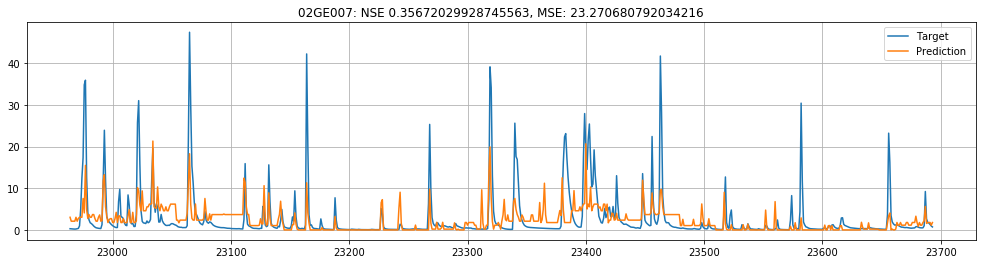

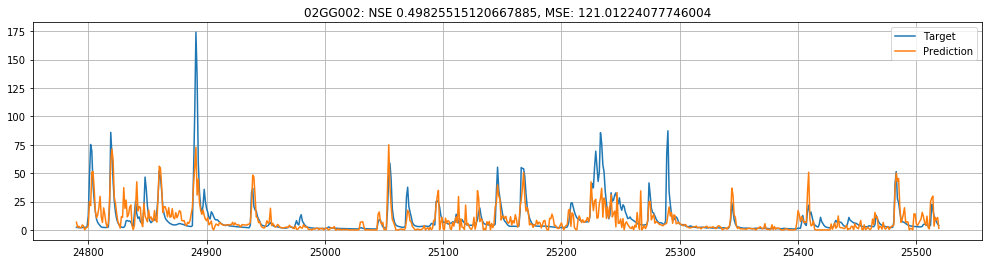

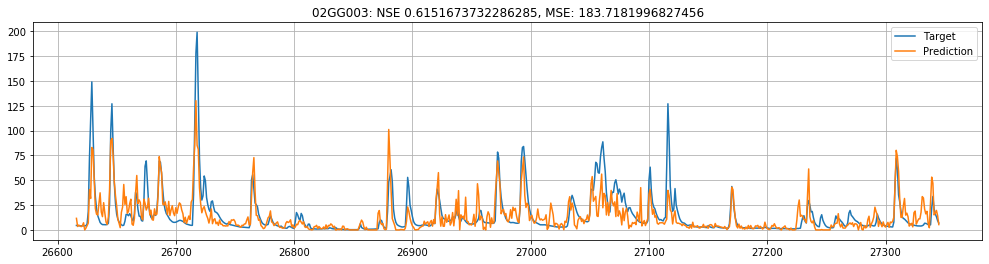

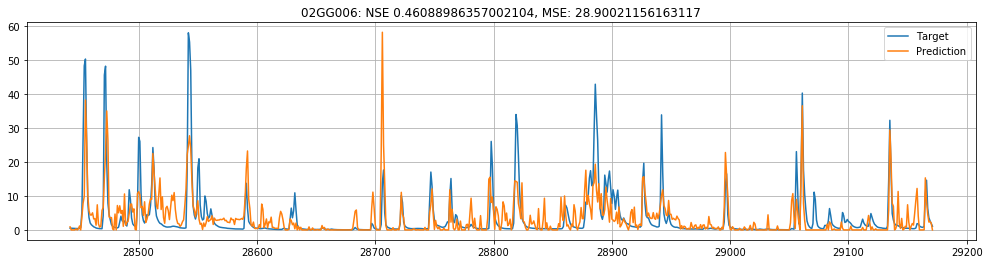

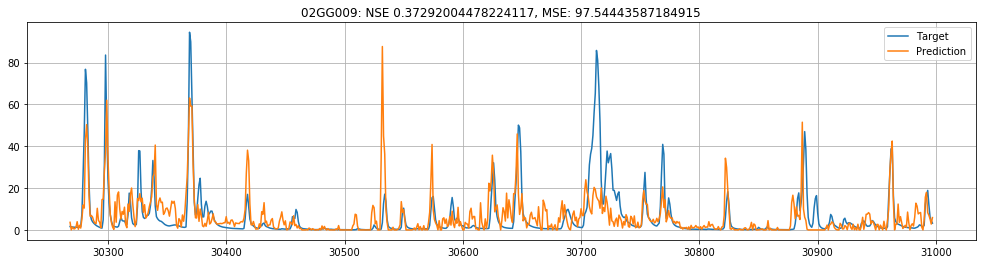

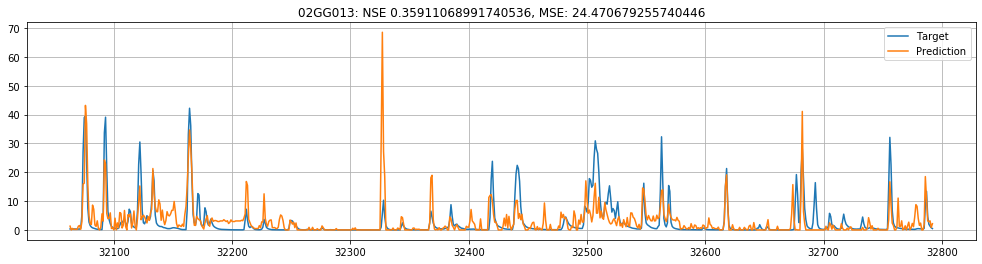

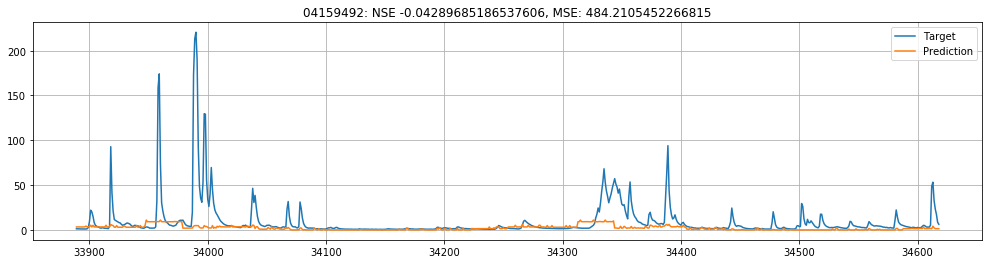

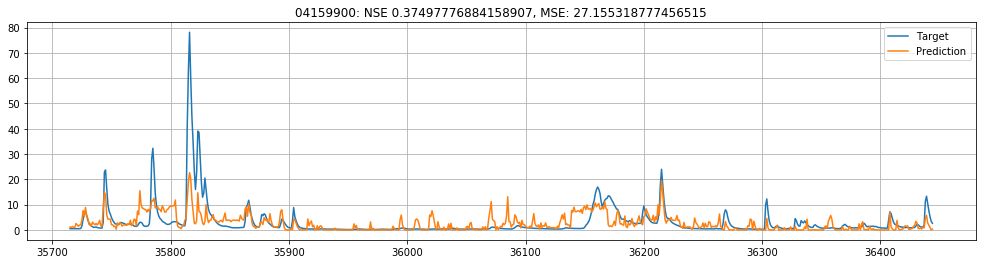

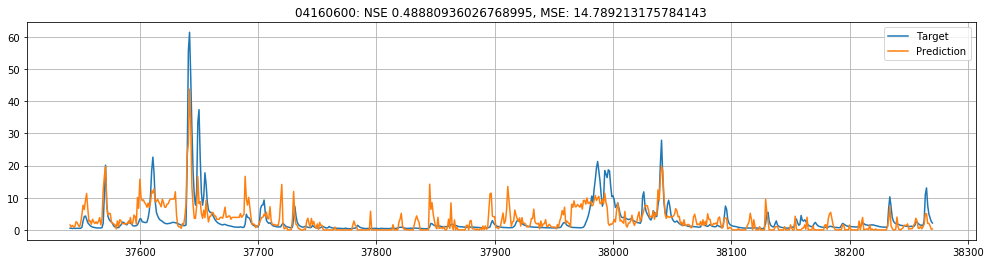

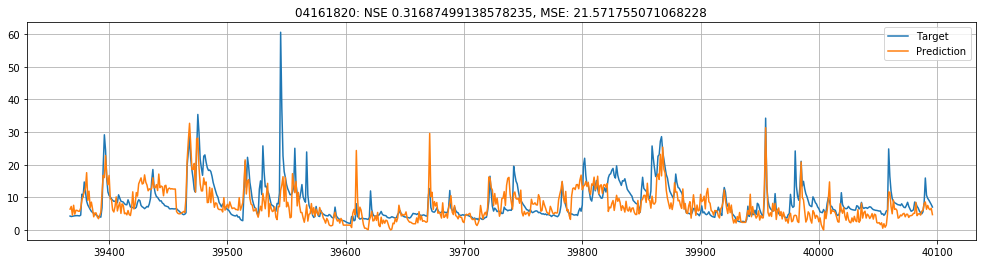

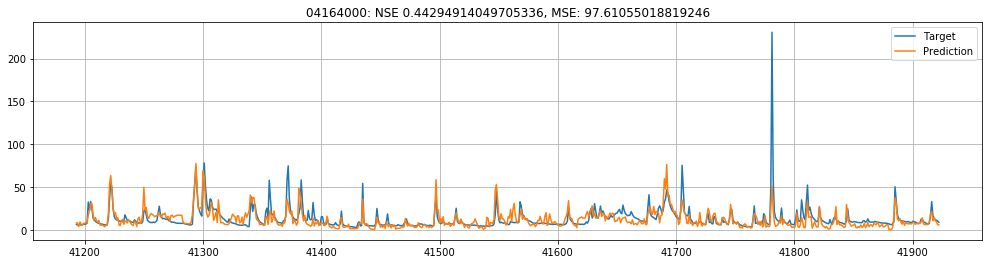

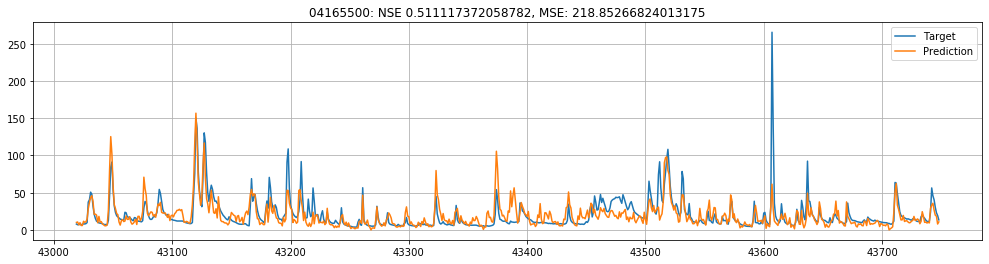

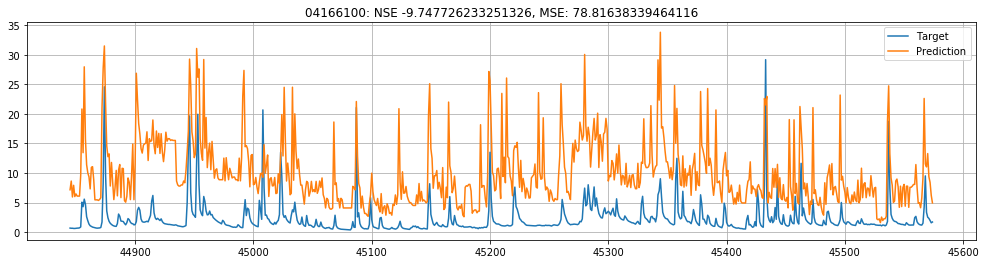

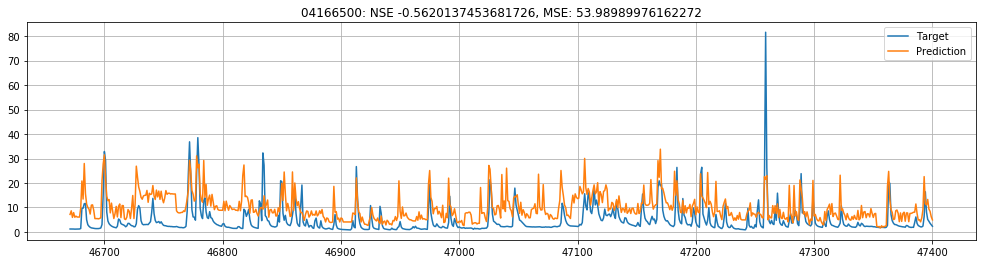

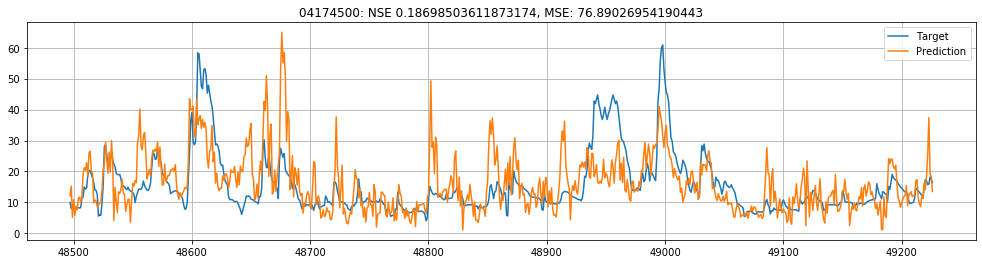

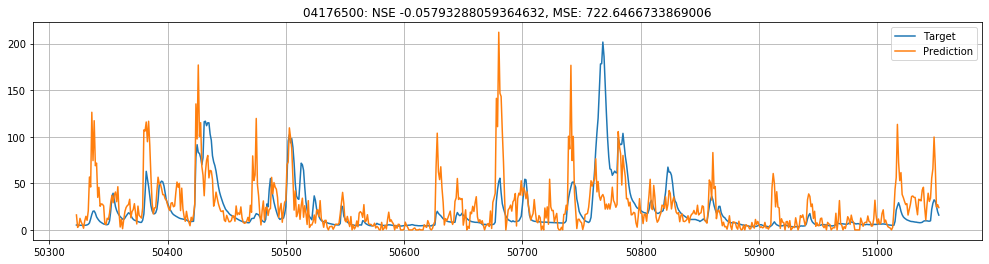

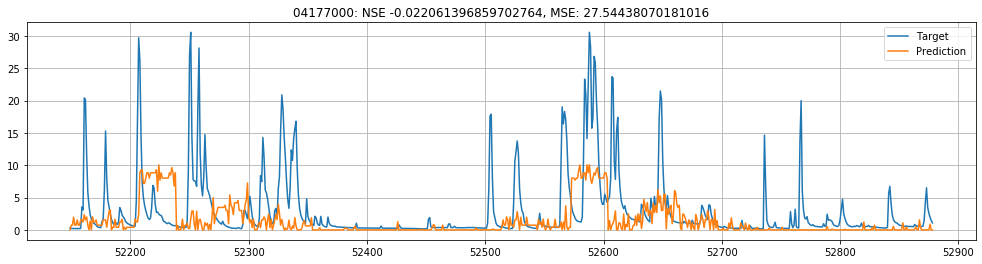

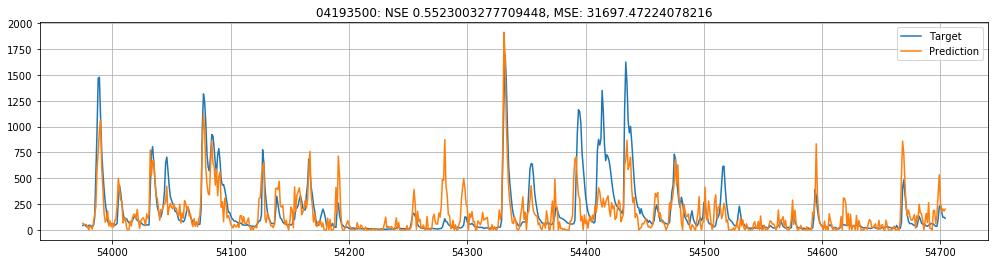

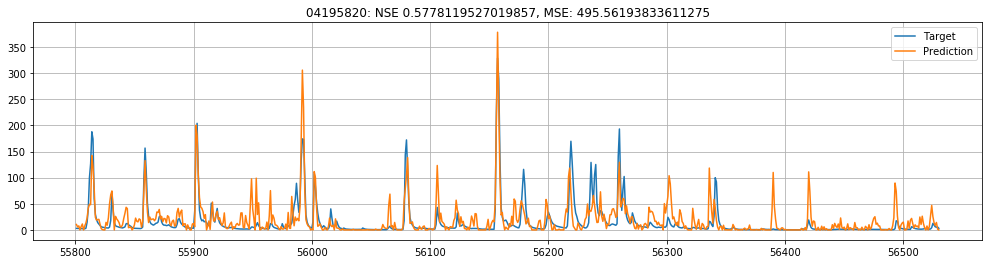

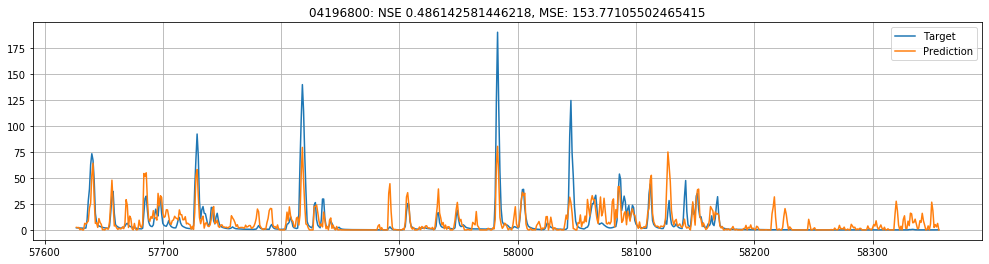

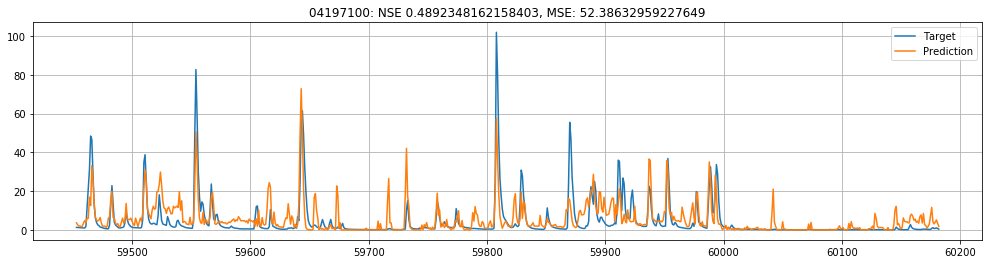

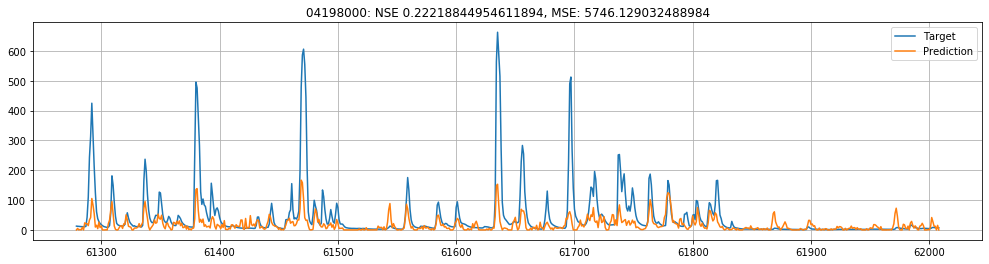

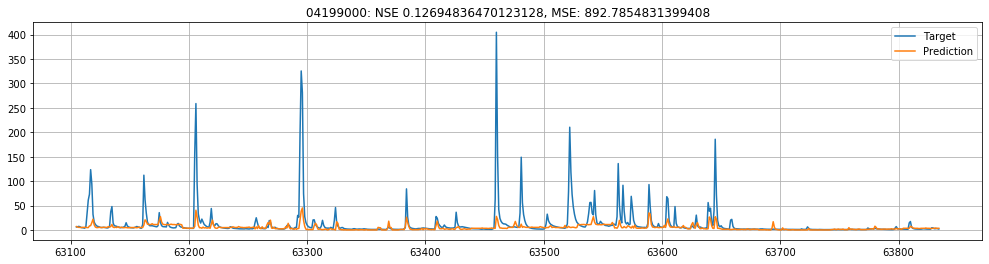

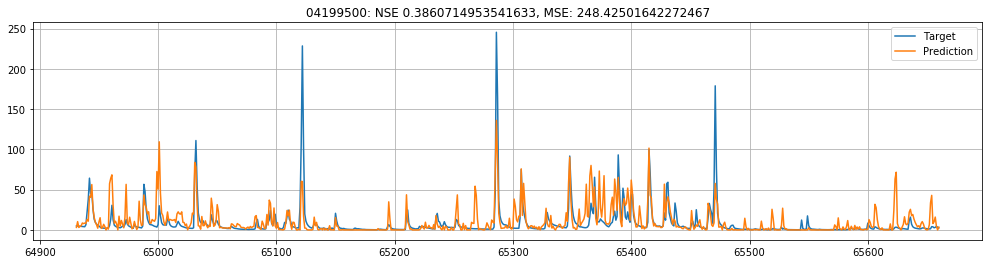

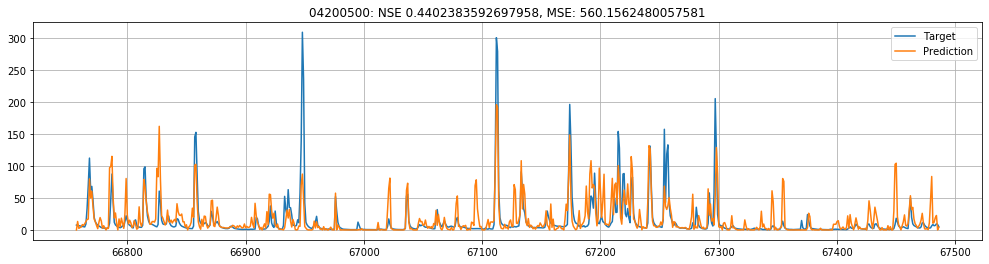

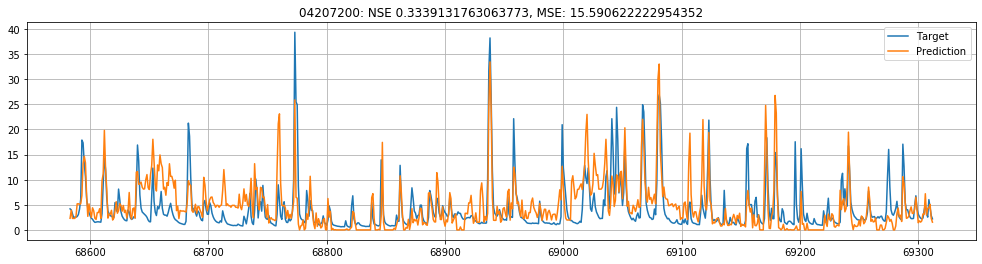

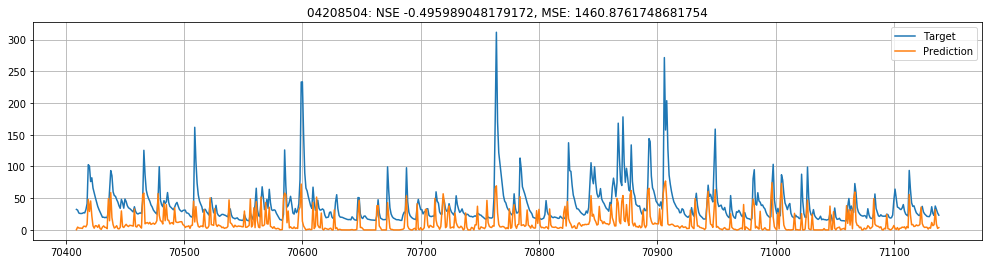

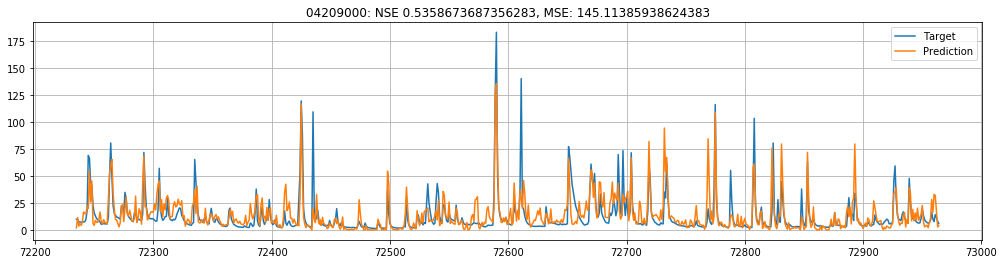

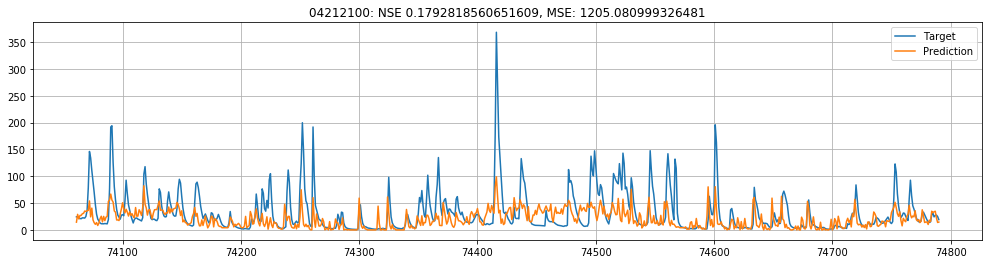

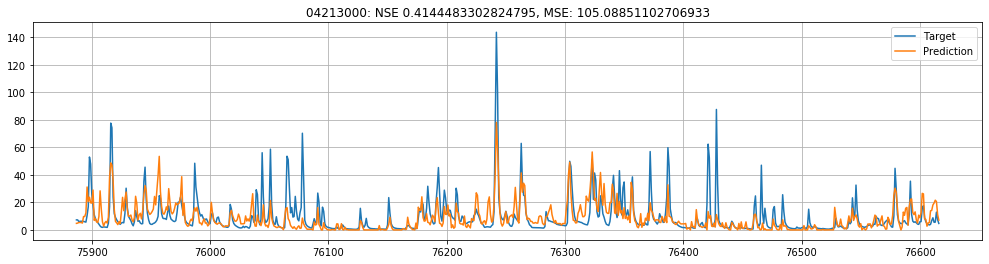

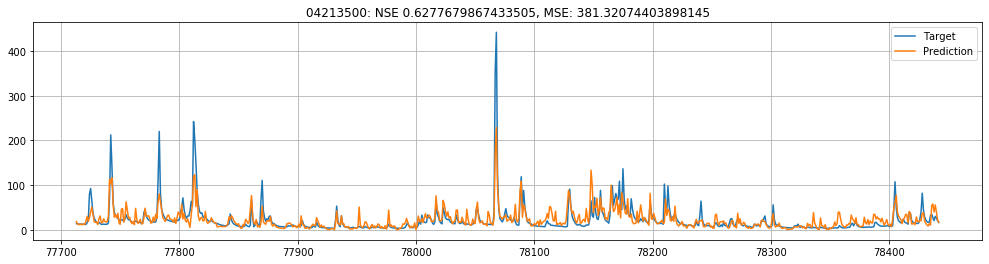

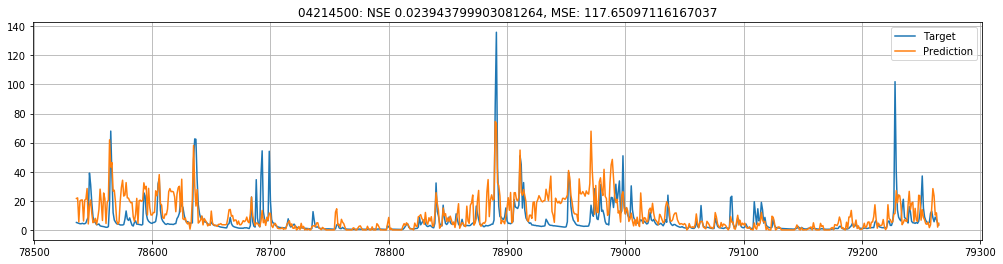

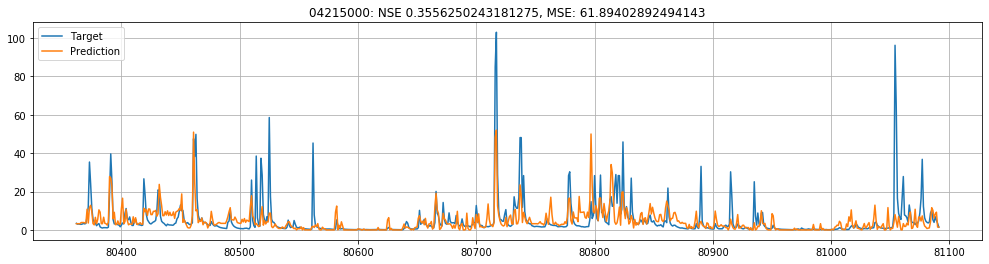

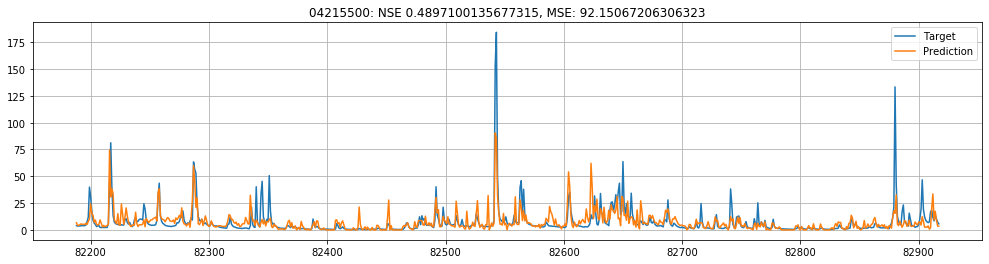

In [17]:
train_nse_list = []
train_mse_list = []
test_nse_list = []
test_mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    if station in test_stations:
        test_nse_list.append(nse)
        test_mse_list.append(mse)
    else:
        train_nse_list.append(nse)
        train_mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Train Median NSE (clipped to 0)', np.median(train_nse_list), '/ Min', np.min(train_nse_list), '/ Max', np.max(train_nse_list))
print('Train Median MSE (clipped to 0)', np.median(train_mse_list), '/ Min', np.min(train_mse_list), '/ Max', np.max(train_mse_list))
print('Test Median NSE (clipped to 0)', np.median(test_nse_list), '/ Min', np.min(test_nse_list), '/ Max', np.max(test_nse_list))
print('Test Median MSE (clipped to 0)', np.median(test_mse_list), '/ Min', np.min(test_mse_list), '/ Max', np.max(test_mse_list))

In [11]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_generalizationTest', predict[['date', 'station', 'runoff', 'actual', 'is_test_station']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

'XGBoost_VIC_aggregateForcings_generalizationTest_20190728-124418.pkl'

In [12]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_generalizationTest', m, 'all', time_stamp, model_type='sklearn')

Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_generalizationTest_all_20190728-124418.pkl
